In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                                                             | 0/50000 [00:00<?, ?it/s]

  9%|████████████▍                                                                                                                                  | 4359/50000 [00:00<00:01, 43585.78it/s]

 17%|█████████████████████████                                                                                                                      | 8747/50000 [00:00<00:00, 43756.05it/s]

 26%|█████████████████████████████████████▎                                                                                                        | 13128/50000 [00:00<00:00, 43775.93it/s]

 35%|█████████████████████████████████████████████████▋                                                                                            | 17506/50000 [00:00<00:00, 43761.08it/s]

 44%|██████████████████████████████████████████████████████████████▏                                                                               | 21883/50000 [00:00<00:00, 42639.07it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                   | 26266/50000 [00:00<00:00, 43034.90it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                       | 30626/50000 [00:00<00:00, 43216.22it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 35019/50000 [00:00<00:00, 43440.42it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 39366/50000 [00:00<00:00, 43272.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43763/50000 [00:01<00:00, 43484.25it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 48157/50000 [00:01<00:00, 43621.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43385.39it/s]

Files already downloaded and verified


  0%|                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                     | 4037/10000 [00:00<00:00, 40361.47it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8411/10000 [00:00<00:00, 42347.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 41651.36it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 yk4jbpb0


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                               | 0/313 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/313 [00:00<03:30,  1.48it/s]

  1%|▉                                                                                                                                                      | 2/313 [00:00<01:49,  2.83it/s]

  1%|█▍                                                                                                                                                     | 3/313 [00:00<01:17,  4.01it/s]

  1%|█▉                                                                                                                                                     | 4/313 [00:01<01:02,  4.97it/s]

  2%|██▍                                                                                                                                                    | 5/313 [00:01<00:53,  5.72it/s]

  2%|██▉                                                                                                                                                    | 6/313 [00:01<00:48,  6.30it/s]

  2%|███▍                                                                                                                                                   | 7/313 [00:01<00:45,  6.73it/s]

  3%|███▊                                                                                                                                                   | 8/313 [00:01<00:43,  7.04it/s]

  3%|████▎                                                                                                                                                  | 9/313 [00:01<00:41,  7.27it/s]

  3%|████▊                                                                                                                                                 | 10/313 [00:01<00:40,  7.43it/s]

  4%|█████▎                                                                                                                                                | 11/313 [00:01<00:40,  7.54it/s]

  4%|█████▊                                                                                                                                                | 12/313 [00:02<00:39,  7.63it/s]

  4%|██████▏                                                                                                                                               | 13/313 [00:02<00:39,  7.69it/s]

  4%|██████▋                                                                                                                                               | 14/313 [00:02<00:38,  7.73it/s]

  5%|███████▏                                                                                                                                              | 15/313 [00:02<00:38,  7.75it/s]

  5%|███████▋                                                                                                                                              | 16/313 [00:02<00:38,  7.78it/s]

  5%|████████▏                                                                                                                                             | 17/313 [00:02<00:37,  7.80it/s]

  6%|████████▋                                                                                                                                             | 18/313 [00:02<00:37,  7.81it/s]

  6%|█████████                                                                                                                                             | 19/313 [00:02<00:37,  7.82it/s]

  6%|█████████▌                                                                                                                                            | 20/313 [00:03<00:37,  7.82it/s]

  7%|██████████                                                                                                                                            | 21/313 [00:03<00:37,  7.83it/s]

  7%|██████████▌                                                                                                                                           | 22/313 [00:03<00:37,  7.82it/s]

  7%|███████████                                                                                                                                           | 23/313 [00:03<00:37,  7.82it/s]

  8%|███████████▌                                                                                                                                          | 24/313 [00:03<00:36,  7.81it/s]

  8%|███████████▉                                                                                                                                          | 25/313 [00:03<00:36,  7.82it/s]

  8%|████████████▍                                                                                                                                         | 26/313 [00:03<00:36,  7.81it/s]

  9%|████████████▉                                                                                                                                         | 27/313 [00:03<00:36,  7.82it/s]

  9%|█████████████▍                                                                                                                                        | 28/313 [00:04<00:36,  7.82it/s]

  9%|█████████████▉                                                                                                                                        | 29/313 [00:04<00:36,  7.83it/s]

 10%|██████████████▍                                                                                                                                       | 30/313 [00:04<00:36,  7.83it/s]

 10%|██████████████▊                                                                                                                                       | 31/313 [00:04<00:36,  7.82it/s]

 10%|███████████████▎                                                                                                                                      | 32/313 [00:04<00:35,  7.83it/s]

 11%|███████████████▊                                                                                                                                      | 33/313 [00:04<00:35,  7.83it/s]

 11%|████████████████▎                                                                                                                                     | 34/313 [00:04<00:35,  7.83it/s]

 11%|████████████████▊                                                                                                                                     | 35/313 [00:05<00:35,  7.83it/s]

 12%|█████████████████▎                                                                                                                                    | 36/313 [00:05<00:35,  7.83it/s]

 12%|█████████████████▋                                                                                                                                    | 37/313 [00:05<00:35,  7.82it/s]

 12%|██████████████████▏                                                                                                                                   | 38/313 [00:05<00:35,  7.81it/s]

 12%|██████████████████▋                                                                                                                                   | 39/313 [00:05<00:35,  7.82it/s]

 13%|███████████████████▏                                                                                                                                  | 40/313 [00:05<00:34,  7.83it/s]

 13%|███████████████████▋                                                                                                                                  | 41/313 [00:05<00:34,  7.83it/s]

 13%|████████████████████▏                                                                                                                                 | 42/313 [00:05<00:34,  7.83it/s]

 14%|████████████████████▌                                                                                                                                 | 43/313 [00:06<00:34,  7.83it/s]

 14%|█████████████████████                                                                                                                                 | 44/313 [00:06<00:34,  7.83it/s]

 14%|█████████████████████▌                                                                                                                                | 45/313 [00:06<00:34,  7.83it/s]

 15%|██████████████████████                                                                                                                                | 46/313 [00:06<00:34,  7.84it/s]

 15%|██████████████████████▌                                                                                                                               | 47/313 [00:06<00:33,  7.83it/s]

 15%|███████████████████████                                                                                                                               | 48/313 [00:06<00:33,  7.83it/s]

 16%|███████████████████████▍                                                                                                                              | 49/313 [00:06<00:33,  7.83it/s]

 16%|███████████████████████▉                                                                                                                              | 50/313 [00:06<00:33,  7.83it/s]

 16%|████████████████████████▍                                                                                                                             | 51/313 [00:07<00:33,  7.82it/s]

 17%|████████████████████████▉                                                                                                                             | 52/313 [00:07<00:33,  7.82it/s]

 17%|█████████████████████████▍                                                                                                                            | 53/313 [00:07<00:33,  7.82it/s]

 17%|█████████████████████████▉                                                                                                                            | 54/313 [00:07<00:33,  7.83it/s]

 18%|██████████████████████████▎                                                                                                                           | 55/313 [00:07<00:32,  7.83it/s]

 18%|██████████████████████████▊                                                                                                                           | 56/313 [00:07<00:32,  7.83it/s]

 18%|███████████████████████████▎                                                                                                                          | 57/313 [00:07<00:32,  7.83it/s]

 19%|███████████████████████████▊                                                                                                                          | 58/313 [00:07<00:32,  7.83it/s]

 19%|████████████████████████████▎                                                                                                                         | 59/313 [00:08<00:32,  7.84it/s]

 19%|████████████████████████████▊                                                                                                                         | 60/313 [00:08<00:32,  7.83it/s]

 19%|█████████████████████████████▏                                                                                                                        | 61/313 [00:08<00:32,  7.82it/s]

 20%|█████████████████████████████▋                                                                                                                        | 62/313 [00:08<00:32,  7.83it/s]

 20%|██████████████████████████████▏                                                                                                                       | 63/313 [00:08<00:31,  7.82it/s]

 20%|██████████████████████████████▋                                                                                                                       | 64/313 [00:08<00:31,  7.81it/s]

 21%|███████████████████████████████▏                                                                                                                      | 65/313 [00:08<00:31,  7.81it/s]

 21%|███████████████████████████████▋                                                                                                                      | 66/313 [00:08<00:31,  7.81it/s]

 21%|████████████████████████████████                                                                                                                      | 67/313 [00:09<00:31,  7.81it/s]

 22%|████████████████████████████████▌                                                                                                                     | 68/313 [00:09<00:31,  7.81it/s]

 22%|█████████████████████████████████                                                                                                                     | 69/313 [00:09<00:31,  7.81it/s]

 22%|█████████████████████████████████▌                                                                                                                    | 70/313 [00:09<00:31,  7.81it/s]

 23%|██████████████████████████████████                                                                                                                    | 71/313 [00:09<00:31,  7.80it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 72/313 [00:09<00:30,  7.79it/s]

 23%|██████████████████████████████████▉                                                                                                                   | 73/313 [00:09<00:30,  7.79it/s]

 24%|███████████████████████████████████▍                                                                                                                  | 74/313 [00:10<00:30,  7.80it/s]

 24%|███████████████████████████████████▉                                                                                                                  | 75/313 [00:10<00:30,  7.80it/s]

 24%|████████████████████████████████████▍                                                                                                                 | 76/313 [00:10<00:30,  7.80it/s]

 25%|████████████████████████████████████▉                                                                                                                 | 77/313 [00:10<00:30,  7.81it/s]

 25%|█████████████████████████████████████▍                                                                                                                | 78/313 [00:10<00:30,  7.81it/s]

 25%|█████████████████████████████████████▊                                                                                                                | 79/313 [00:10<00:29,  7.81it/s]

 26%|██████████████████████████████████████▎                                                                                                               | 80/313 [00:10<00:29,  7.81it/s]

 26%|██████████████████████████████████████▊                                                                                                               | 81/313 [00:10<00:29,  7.81it/s]

 26%|███████████████████████████████████████▎                                                                                                              | 82/313 [00:11<00:29,  7.81it/s]

 27%|███████████████████████████████████████▊                                                                                                              | 83/313 [00:11<00:29,  7.80it/s]

 27%|████████████████████████████████████████▎                                                                                                             | 84/313 [00:11<00:29,  7.81it/s]

 27%|████████████████████████████████████████▋                                                                                                             | 85/313 [00:11<00:29,  7.81it/s]

 27%|█████████████████████████████████████████▏                                                                                                            | 86/313 [00:11<00:29,  7.82it/s]

 28%|█████████████████████████████████████████▋                                                                                                            | 87/313 [00:11<00:28,  7.82it/s]

 28%|██████████████████████████████████████████▏                                                                                                           | 88/313 [00:11<00:28,  7.82it/s]

 28%|██████████████████████████████████████████▋                                                                                                           | 89/313 [00:11<00:28,  7.80it/s]

 29%|███████████████████████████████████████████▏                                                                                                          | 90/313 [00:12<00:28,  7.80it/s]

 29%|███████████████████████████████████████████▌                                                                                                          | 91/313 [00:12<00:28,  7.80it/s]

 29%|████████████████████████████████████████████                                                                                                          | 92/313 [00:12<00:28,  7.79it/s]

 30%|████████████████████████████████████████████▌                                                                                                         | 93/313 [00:12<00:28,  7.80it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 94/313 [00:12<00:28,  7.79it/s]

 30%|█████████████████████████████████████████████▌                                                                                                        | 95/313 [00:12<00:27,  7.80it/s]

 31%|██████████████████████████████████████████████                                                                                                        | 96/313 [00:12<00:27,  7.81it/s]

 31%|██████████████████████████████████████████████▍                                                                                                       | 97/313 [00:12<00:27,  7.81it/s]

 31%|██████████████████████████████████████████████▉                                                                                                       | 98/313 [00:13<00:27,  7.81it/s]

 32%|███████████████████████████████████████████████▍                                                                                                      | 99/313 [00:13<00:27,  7.81it/s]

 32%|███████████████████████████████████████████████▌                                                                                                     | 100/313 [00:13<00:27,  7.81it/s]

 32%|████████████████████████████████████████████████                                                                                                     | 101/313 [00:13<00:27,  7.82it/s]

 33%|████████████████████████████████████████████████▌                                                                                                    | 102/313 [00:13<00:26,  7.82it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 103/313 [00:13<00:26,  7.82it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                   | 104/313 [00:13<00:26,  7.82it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                   | 105/313 [00:13<00:26,  7.82it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                  | 106/313 [00:14<00:26,  7.81it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 107/313 [00:14<00:26,  7.81it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                 | 108/313 [00:14<00:26,  7.82it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 109/313 [00:14<00:26,  7.79it/s]

 35%|████████████████████████████████████████████████████▎                                                                                                | 110/313 [00:14<00:26,  7.79it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                | 111/313 [00:14<00:25,  7.80it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                               | 112/313 [00:14<00:25,  7.80it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                               | 113/313 [00:15<00:25,  7.81it/s]

 36%|██████████████████████████████████████████████████████▎                                                                                              | 114/313 [00:15<00:25,  7.81it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                              | 115/313 [00:15<00:25,  7.82it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                             | 116/313 [00:15<00:25,  7.82it/s]

 37%|███████████████████████████████████████████████████████▋                                                                                             | 117/313 [00:15<00:25,  7.81it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                            | 118/313 [00:15<00:24,  7.82it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                            | 119/313 [00:15<00:24,  7.82it/s]

 38%|█████████████████████████████████████████████████████████                                                                                            | 120/313 [00:15<00:24,  7.82it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                           | 121/313 [00:16<00:24,  7.82it/s]

 39%|██████████████████████████████████████████████████████████                                                                                           | 122/313 [00:16<00:24,  7.81it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                          | 123/313 [00:16<00:24,  7.80it/s]

 40%|███████████████████████████████████████████████████████████                                                                                          | 124/313 [00:16<00:24,  7.79it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 125/313 [00:16<00:24,  7.78it/s]

 40%|███████████████████████████████████████████████████████████▉                                                                                         | 126/313 [00:16<00:24,  7.78it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                        | 127/313 [00:16<00:23,  7.77it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                        | 128/313 [00:16<00:23,  7.78it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                       | 129/313 [00:17<00:23,  7.78it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                       | 130/313 [00:17<00:23,  7.79it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                      | 131/313 [00:17<00:23,  7.79it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                      | 132/313 [00:17<00:23,  7.79it/s]

 42%|███████████████████████████████████████████████████████████████▎                                                                                     | 133/313 [00:17<00:23,  7.79it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                     | 134/313 [00:17<00:22,  7.79it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                    | 135/313 [00:17<00:22,  7.80it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 136/313 [00:17<00:22,  7.80it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                   | 137/313 [00:18<00:22,  7.81it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                   | 138/313 [00:18<00:22,  7.81it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 139/313 [00:18<00:22,  7.82it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                  | 140/313 [00:18<00:22,  7.82it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                  | 141/313 [00:18<00:21,  7.83it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                 | 142/313 [00:18<00:21,  7.82it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                                 | 143/313 [00:18<00:21,  7.83it/s]

 46%|████████████████████████████████████████████████████████████████████▌                                                                                | 144/313 [00:18<00:21,  7.83it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                | 145/313 [00:19<00:21,  7.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                               | 146/313 [00:19<00:21,  7.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▉                                                                               | 147/313 [00:19<00:21,  7.83it/s]

 47%|██████████████████████████████████████████████████████████████████████▍                                                                              | 148/313 [00:19<00:21,  7.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 149/313 [00:19<00:20,  7.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▍                                                                             | 150/313 [00:19<00:20,  7.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▉                                                                             | 151/313 [00:19<00:20,  7.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                            | 152/313 [00:19<00:20,  7.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                            | 153/313 [00:20<00:20,  7.82it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 154/313 [00:20<00:20,  7.81it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                           | 155/313 [00:20<00:20,  7.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                          | 156/313 [00:20<00:20,  7.81it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                          | 157/313 [00:20<00:19,  7.81it/s]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 158/313 [00:20<00:19,  7.80it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                         | 159/313 [00:20<00:19,  7.80it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                        | 160/313 [00:21<00:19,  7.80it/s]

 51%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 161/313 [00:21<00:19,  7.80it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                        | 162/313 [00:21<00:19,  7.80it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                       | 163/313 [00:21<00:19,  7.81it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 164/313 [00:21<00:19,  7.81it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                      | 165/313 [00:21<00:18,  7.81it/s]

 53%|███████████████████████████████████████████████████████████████████████████████                                                                      | 166/313 [00:21<00:18,  7.81it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                     | 167/313 [00:21<00:18,  7.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                     | 168/313 [00:22<00:18,  7.82it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▍                                                                    | 169/313 [00:22<00:18,  7.82it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                    | 170/313 [00:22<00:18,  7.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                   | 171/313 [00:22<00:18,  7.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                   | 172/313 [00:22<00:18,  7.82it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                  | 173/313 [00:22<00:17,  7.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 174/313 [00:22<00:17,  7.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 175/313 [00:22<00:17,  7.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 176/313 [00:23<00:17,  7.81it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 177/313 [00:23<00:17,  7.81it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                                | 178/313 [00:23<00:17,  7.81it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▏                                                               | 179/313 [00:23<00:17,  7.80it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                               | 180/313 [00:23<00:17,  7.79it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 181/313 [00:23<00:16,  7.79it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 182/313 [00:23<00:16,  7.79it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                              | 183/313 [00:23<00:16,  7.78it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▌                                                             | 184/313 [00:24<00:16,  7.79it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████                                                             | 185/313 [00:24<00:16,  7.81it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 186/313 [00:24<00:16,  7.81it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████                                                            | 187/313 [00:24<00:16,  7.81it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 188/313 [00:24<00:15,  7.81it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 189/313 [00:24<00:15,  7.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 190/313 [00:24<00:15,  7.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 191/313 [00:24<00:15,  7.81it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 192/313 [00:25<00:15,  7.81it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 193/313 [00:25<00:15,  7.82it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 194/313 [00:25<00:15,  7.82it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 195/313 [00:25<00:15,  7.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 196/313 [00:25<00:14,  7.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 197/313 [00:25<00:14,  7.83it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 198/313 [00:25<00:14,  7.83it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 199/313 [00:26<00:14,  7.83it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 200/313 [00:26<00:14,  7.83it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 201/313 [00:26<00:14,  7.83it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 202/313 [00:26<00:14,  7.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 203/313 [00:26<00:14,  7.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 204/313 [00:26<00:13,  7.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 205/313 [00:26<00:13,  7.83it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 206/313 [00:26<00:13,  7.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 207/313 [00:27<00:13,  7.81it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 208/313 [00:27<00:13,  7.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 209/313 [00:27<00:13,  7.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 210/313 [00:27<00:13,  7.82it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 211/313 [00:27<00:13,  7.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 212/313 [00:27<00:12,  7.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 213/313 [00:27<00:12,  7.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 214/313 [00:27<00:12,  7.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 215/313 [00:28<00:12,  7.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 216/313 [00:28<00:12,  7.82it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 217/313 [00:28<00:12,  7.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 218/313 [00:28<00:12,  7.83it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 219/313 [00:28<00:12,  7.83it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 220/313 [00:28<00:11,  7.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 221/313 [00:28<00:11,  7.80it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 222/313 [00:28<00:11,  7.81it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 223/313 [00:29<00:11,  7.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 224/313 [00:29<00:11,  7.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 225/313 [00:29<00:11,  7.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 226/313 [00:29<00:11,  7.83it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 227/313 [00:29<00:10,  7.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 228/313 [00:29<00:10,  7.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 229/313 [00:29<00:10,  7.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 230/313 [00:29<00:10,  7.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 231/313 [00:30<00:10,  7.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 232/313 [00:30<00:10,  7.81it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 233/313 [00:30<00:10,  7.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 234/313 [00:30<00:10,  7.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 235/313 [00:30<00:09,  7.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 236/313 [00:30<00:09,  7.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 237/313 [00:30<00:09,  7.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 238/313 [00:30<00:09,  7.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 239/313 [00:31<00:09,  7.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 240/313 [00:31<00:09,  7.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 241/313 [00:31<00:09,  7.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 242/313 [00:31<00:09,  7.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 243/313 [00:31<00:08,  7.81it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 244/313 [00:31<00:08,  7.80it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 245/313 [00:31<00:08,  7.80it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 246/313 [00:32<00:08,  7.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 247/313 [00:32<00:08,  7.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 248/313 [00:32<00:08,  7.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 249/313 [00:32<00:08,  7.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 250/313 [00:32<00:08,  7.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 251/313 [00:32<00:07,  7.81it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 252/313 [00:32<00:07,  7.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 253/313 [00:32<00:07,  7.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 254/313 [00:33<00:07,  7.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 255/313 [00:33<00:07,  7.79it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 256/313 [00:33<00:07,  7.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 257/313 [00:33<00:07,  7.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 258/313 [00:33<00:07,  7.80it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 259/313 [00:33<00:06,  7.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 260/313 [00:33<00:06,  7.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 261/313 [00:33<00:06,  7.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 262/313 [00:34<00:06,  7.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 263/313 [00:34<00:06,  7.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 264/313 [00:34<00:06,  7.80it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 265/313 [00:34<00:06,  7.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 266/313 [00:34<00:06,  7.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 267/313 [00:34<00:05,  7.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 268/313 [00:34<00:05,  7.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 269/313 [00:34<00:05,  7.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 270/313 [00:35<00:05,  7.82it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 271/313 [00:35<00:05,  7.82it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 272/313 [00:35<00:05,  7.82it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 273/313 [00:35<00:05,  7.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 274/313 [00:35<00:04,  7.82it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 275/313 [00:35<00:04,  7.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 276/313 [00:35<00:04,  7.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 277/313 [00:35<00:04,  7.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 278/313 [00:36<00:04,  7.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 279/313 [00:36<00:04,  7.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 280/313 [00:36<00:04,  7.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 281/313 [00:36<00:04,  7.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 282/313 [00:36<00:03,  7.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 283/313 [00:36<00:03,  7.83it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 284/313 [00:36<00:03,  7.82it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 285/313 [00:37<00:03,  7.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 286/313 [00:37<00:03,  7.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 287/313 [00:37<00:03,  7.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 288/313 [00:37<00:03,  7.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 289/313 [00:37<00:03,  7.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 290/313 [00:37<00:02,  7.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 291/313 [00:37<00:02,  7.82it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 292/313 [00:37<00:02,  7.82it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 293/313 [00:38<00:02,  7.82it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 294/313 [00:38<00:02,  7.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 295/313 [00:38<00:02,  7.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 296/313 [00:38<00:02,  7.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 297/313 [00:38<00:02,  7.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 298/313 [00:38<00:01,  7.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 299/313 [00:38<00:01,  7.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 300/313 [00:38<00:01,  7.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 301/313 [00:39<00:01,  7.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 302/313 [00:39<00:01,  7.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 303/313 [00:39<00:01,  7.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 304/313 [00:39<00:01,  7.82it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 305/313 [00:39<00:01,  7.80it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 306/313 [00:39<00:00,  7.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 307/313 [00:39<00:00,  7.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 308/313 [00:39<00:00,  7.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 309/313 [00:40<00:00,  7.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 310/313 [00:40<00:00,  7.83it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 311/313 [00:40<00:00,  7.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 312/313 [00:40<00:00,  7.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:40<00:00,  7.71it/s]

train - OK


  0%|                                                                                                                                                                | 0/79 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                      | 1/79 [00:00<00:18,  4.14it/s]

  3%|███▊                                                                                                                                                    | 2/79 [00:00<00:13,  5.71it/s]

  4%|█████▊                                                                                                                                                  | 3/79 [00:00<00:11,  6.51it/s]

  5%|███████▋                                                                                                                                                | 4/79 [00:00<00:10,  6.98it/s]

  6%|█████████▌                                                                                                                                              | 5/79 [00:00<00:10,  7.26it/s]

  8%|███████████▌                                                                                                                                            | 6/79 [00:00<00:09,  7.44it/s]

  9%|█████████████▍                                                                                                                                          | 7/79 [00:01<00:09,  7.57it/s]

 10%|███████████████▍                                                                                                                                        | 8/79 [00:01<00:09,  7.65it/s]

 11%|█████████████████▎                                                                                                                                      | 9/79 [00:01<00:09,  7.71it/s]

 13%|███████████████████                                                                                                                                    | 10/79 [00:01<00:08,  7.75it/s]

 14%|█████████████████████                                                                                                                                  | 11/79 [00:01<00:08,  7.77it/s]

 15%|██████████████████████▉                                                                                                                                | 12/79 [00:01<00:08,  7.79it/s]

 16%|████████████████████████▊                                                                                                                              | 13/79 [00:01<00:08,  7.80it/s]

 18%|██████████████████████████▊                                                                                                                            | 14/79 [00:01<00:08,  7.82it/s]

 19%|████████████████████████████▋                                                                                                                          | 15/79 [00:02<00:08,  7.82it/s]

 20%|██████████████████████████████▌                                                                                                                        | 16/79 [00:02<00:08,  7.83it/s]

 22%|████████████████████████████████▍                                                                                                                      | 17/79 [00:02<00:07,  7.83it/s]

 23%|██████████████████████████████████▍                                                                                                                    | 18/79 [00:02<00:07,  7.83it/s]

 24%|████████████████████████████████████▎                                                                                                                  | 19/79 [00:02<00:07,  7.83it/s]

 25%|██████████████████████████████████████▏                                                                                                                | 20/79 [00:02<00:07,  7.83it/s]

 27%|████████████████████████████████████████▏                                                                                                              | 21/79 [00:02<00:07,  7.83it/s]

 28%|██████████████████████████████████████████                                                                                                             | 22/79 [00:02<00:07,  7.83it/s]

 29%|███████████████████████████████████████████▉                                                                                                           | 23/79 [00:03<00:07,  7.84it/s]

 30%|█████████████████████████████████████████████▊                                                                                                         | 24/79 [00:03<00:07,  7.84it/s]

 32%|███████████████████████████████████████████████▊                                                                                                       | 25/79 [00:03<00:06,  7.85it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                     | 26/79 [00:03<00:06,  7.84it/s]

 34%|███████████████████████████████████████████████████▌                                                                                                   | 27/79 [00:03<00:06,  7.85it/s]

 35%|█████████████████████████████████████████████████████▌                                                                                                 | 28/79 [00:03<00:06,  7.85it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                               | 29/79 [00:03<00:06,  7.84it/s]

 38%|█████████████████████████████████████████████████████████▎                                                                                             | 30/79 [00:03<00:06,  7.84it/s]

 39%|███████████████████████████████████████████████████████████▎                                                                                           | 31/79 [00:04<00:06,  7.84it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                         | 32/79 [00:04<00:05,  7.85it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                        | 33/79 [00:04<00:05,  7.84it/s]

 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 34/79 [00:04<00:05,  7.84it/s]

 44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 35/79 [00:04<00:05,  7.85it/s]

 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 36/79 [00:04<00:05,  7.85it/s]

 47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 37/79 [00:04<00:05,  7.84it/s]

 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 38/79 [00:04<00:05,  7.83it/s]

 49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 39/79 [00:05<00:05,  7.83it/s]

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                          | 40/79 [00:05<00:04,  7.84it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 41/79 [00:05<00:04,  7.84it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 42/79 [00:05<00:04,  7.83it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 43/79 [00:05<00:04,  7.83it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 44/79 [00:05<00:04,  7.83it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 45/79 [00:05<00:04,  7.83it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 46/79 [00:05<00:04,  7.83it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 47/79 [00:06<00:04,  7.83it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 48/79 [00:06<00:03,  7.82it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 49/79 [00:06<00:03,  7.83it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 50/79 [00:06<00:03,  7.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 51/79 [00:06<00:03,  7.83it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 52/79 [00:06<00:03,  7.83it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 53/79 [00:06<00:03,  7.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 54/79 [00:07<00:03,  7.84it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 55/79 [00:07<00:03,  7.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 56/79 [00:07<00:02,  7.84it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 57/79 [00:07<00:02,  7.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 58/79 [00:07<00:02,  7.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 59/79 [00:07<00:02,  7.82it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 60/79 [00:07<00:02,  7.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 61/79 [00:07<00:02,  7.80it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 62/79 [00:08<00:02,  7.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 63/79 [00:08<00:02,  7.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 64/79 [00:08<00:01,  7.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 65/79 [00:08<00:01,  7.81it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 66/79 [00:08<00:01,  7.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 67/79 [00:08<00:01,  7.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 68/79 [00:08<00:01,  7.81it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 69/79 [00:08<00:01,  7.81it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 70/79 [00:09<00:01,  7.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 71/79 [00:09<00:01,  7.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 72/79 [00:09<00:00,  7.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 73/79 [00:09<00:00,  7.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 74/79 [00:09<00:00,  7.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75/79 [00:09<00:00,  7.83it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76/79 [00:09<00:00,  7.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77/79 [00:09<00:00,  7.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78/79 [00:10<00:00,  7.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.76it/s]

val - OK


  0%|                                                                                                                                                                | 0/79 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                      | 1/79 [00:00<00:20,  3.85it/s]

  3%|███▊                                                                                                                                                    | 2/79 [00:00<00:14,  5.48it/s]

  4%|█████▊                                                                                                                                                  | 3/79 [00:00<00:11,  6.34it/s]

  5%|███████▋                                                                                                                                                | 4/79 [00:00<00:10,  6.85it/s]

  6%|█████████▌                                                                                                                                              | 5/79 [00:00<00:10,  7.18it/s]

  8%|███████████▌                                                                                                                                            | 6/79 [00:00<00:09,  7.38it/s]

  9%|█████████████▍                                                                                                                                          | 7/79 [00:01<00:09,  7.52it/s]

 10%|███████████████▍                                                                                                                                        | 8/79 [00:01<00:09,  7.61it/s]

 11%|█████████████████▎                                                                                                                                      | 9/79 [00:01<00:09,  7.68it/s]

 13%|███████████████████                                                                                                                                    | 10/79 [00:01<00:08,  7.73it/s]

 14%|█████████████████████                                                                                                                                  | 11/79 [00:01<00:08,  7.76it/s]

 15%|██████████████████████▉                                                                                                                                | 12/79 [00:01<00:08,  7.78it/s]

 16%|████████████████████████▊                                                                                                                              | 13/79 [00:01<00:08,  7.80it/s]

 18%|██████████████████████████▊                                                                                                                            | 14/79 [00:01<00:08,  7.80it/s]

 19%|████████████████████████████▋                                                                                                                          | 15/79 [00:02<00:08,  7.81it/s]

 20%|██████████████████████████████▌                                                                                                                        | 16/79 [00:02<00:08,  7.81it/s]

 22%|████████████████████████████████▍                                                                                                                      | 17/79 [00:02<00:07,  7.81it/s]

 23%|██████████████████████████████████▍                                                                                                                    | 18/79 [00:02<00:07,  7.82it/s]

 24%|████████████████████████████████████▎                                                                                                                  | 19/79 [00:02<00:07,  7.82it/s]

 25%|██████████████████████████████████████▏                                                                                                                | 20/79 [00:02<00:07,  7.82it/s]

 27%|████████████████████████████████████████▏                                                                                                              | 21/79 [00:02<00:07,  7.81it/s]

 28%|██████████████████████████████████████████                                                                                                             | 22/79 [00:02<00:07,  7.82it/s]

 29%|███████████████████████████████████████████▉                                                                                                           | 23/79 [00:03<00:07,  7.81it/s]

 30%|█████████████████████████████████████████████▊                                                                                                         | 24/79 [00:03<00:07,  7.80it/s]

 32%|███████████████████████████████████████████████▊                                                                                                       | 25/79 [00:03<00:06,  7.79it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                     | 26/79 [00:03<00:06,  7.80it/s]

 34%|███████████████████████████████████████████████████▌                                                                                                   | 27/79 [00:03<00:06,  7.81it/s]

 35%|█████████████████████████████████████████████████████▌                                                                                                 | 28/79 [00:03<00:06,  7.81it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                               | 29/79 [00:03<00:06,  7.81it/s]

 38%|█████████████████████████████████████████████████████████▎                                                                                             | 30/79 [00:03<00:06,  7.82it/s]

 39%|███████████████████████████████████████████████████████████▎                                                                                           | 31/79 [00:04<00:06,  7.83it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                         | 32/79 [00:04<00:06,  7.82it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                        | 33/79 [00:04<00:05,  7.82it/s]

 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 34/79 [00:04<00:05,  7.83it/s]

 44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 35/79 [00:04<00:05,  7.83it/s]

 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 36/79 [00:04<00:05,  7.83it/s]

 47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 37/79 [00:04<00:05,  7.83it/s]

 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 38/79 [00:04<00:05,  7.83it/s]

 49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 39/79 [00:05<00:05,  7.83it/s]

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                          | 40/79 [00:05<00:04,  7.83it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 41/79 [00:05<00:04,  7.83it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 42/79 [00:05<00:04,  7.84it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 43/79 [00:05<00:04,  7.83it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 44/79 [00:05<00:04,  7.83it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 45/79 [00:05<00:04,  7.83it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 46/79 [00:06<00:04,  7.82it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 47/79 [00:06<00:04,  7.83it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 48/79 [00:06<00:03,  7.83it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 49/79 [00:06<00:03,  7.83it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 50/79 [00:06<00:03,  7.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 51/79 [00:06<00:03,  7.83it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 52/79 [00:06<00:03,  7.83it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 53/79 [00:06<00:03,  7.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 54/79 [00:07<00:03,  7.82it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 55/79 [00:07<00:03,  7.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 56/79 [00:07<00:02,  7.82it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 57/79 [00:07<00:02,  7.82it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 58/79 [00:07<00:02,  7.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 59/79 [00:07<00:02,  7.82it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 60/79 [00:07<00:02,  7.82it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 61/79 [00:07<00:02,  7.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 62/79 [00:08<00:02,  7.83it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 63/79 [00:08<00:02,  7.83it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 64/79 [00:08<00:01,  7.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 65/79 [00:08<00:01,  7.81it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 66/79 [00:08<00:01,  7.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 67/79 [00:08<00:01,  7.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 68/79 [00:08<00:01,  7.81it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 69/79 [00:08<00:01,  7.81it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 70/79 [00:09<00:01,  7.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 71/79 [00:09<00:01,  7.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 72/79 [00:09<00:00,  7.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 73/79 [00:09<00:00,  7.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 74/79 [00:09<00:00,  7.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75/79 [00:09<00:00,  7.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76/79 [00:09<00:00,  7.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77/79 [00:09<00:00,  7.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78/79 [00:10<00:00,  7.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.76it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                     | 1/100 [00:00<00:11,  8.91it/s]

  2%|███                                                                                                                                                    | 2/100 [00:00<00:10,  8.95it/s]

  3%|████▌                                                                                                                                                  | 3/100 [00:00<00:10,  8.96it/s]

  4%|██████                                                                                                                                                 | 4/100 [00:00<00:10,  8.98it/s]

  5%|███████▌                                                                                                                                               | 5/100 [00:00<00:10,  8.98it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:10,  8.99it/s]

  7%|██████████▌                                                                                                                                            | 7/100 [00:00<00:10,  8.99it/s]

  8%|████████████                                                                                                                                           | 8/100 [00:00<00:10,  8.99it/s]

  9%|█████████████▌                                                                                                                                         | 9/100 [00:01<00:10,  8.98it/s]

 10%|███████████████                                                                                                                                       | 10/100 [00:01<00:10,  8.98it/s]

 11%|████████████████▌                                                                                                                                     | 11/100 [00:01<00:09,  8.99it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:01<00:09,  8.99it/s]

 13%|███████████████████▌                                                                                                                                  | 13/100 [00:01<00:09,  9.00it/s]

 14%|█████████████████████                                                                                                                                 | 14/100 [00:01<00:09,  9.00it/s]

 15%|██████████████████████▌                                                                                                                               | 15/100 [00:01<00:09,  9.00it/s]

 16%|████████████████████████                                                                                                                              | 16/100 [00:01<00:09,  9.00it/s]

 17%|█████████████████████████▌                                                                                                                            | 17/100 [00:01<00:09,  8.99it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:02<00:09,  8.98it/s]

 19%|████████████████████████████▌                                                                                                                         | 19/100 [00:02<00:09,  8.98it/s]

 20%|██████████████████████████████                                                                                                                        | 20/100 [00:02<00:08,  8.99it/s]

 21%|███████████████████████████████▌                                                                                                                      | 21/100 [00:02<00:08,  8.99it/s]

 22%|█████████████████████████████████                                                                                                                     | 22/100 [00:02<00:08,  9.00it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 23/100 [00:02<00:08,  9.00it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:02<00:08,  9.00it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 25/100 [00:02<00:08,  9.00it/s]

 26%|███████████████████████████████████████                                                                                                               | 26/100 [00:02<00:08,  9.00it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 27/100 [00:03<00:08,  9.00it/s]

 28%|██████████████████████████████████████████                                                                                                            | 28/100 [00:03<00:07,  9.01it/s]

 29%|███████████████████████████████████████████▌                                                                                                          | 29/100 [00:03<00:07,  9.01it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:03<00:07,  9.01it/s]

 31%|██████████████████████████████████████████████▌                                                                                                       | 31/100 [00:03<00:07,  9.01it/s]

 32%|████████████████████████████████████████████████                                                                                                      | 32/100 [00:03<00:07,  9.01it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                    | 33/100 [00:03<00:07,  9.01it/s]

 34%|███████████████████████████████████████████████████                                                                                                   | 34/100 [00:03<00:07,  9.01it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                 | 35/100 [00:03<00:07,  9.01it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:04<00:07,  9.01it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                              | 37/100 [00:04<00:06,  9.01it/s]

 38%|█████████████████████████████████████████████████████████                                                                                             | 38/100 [00:04<00:06,  9.01it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                           | 39/100 [00:04<00:06,  9.01it/s]

 40%|████████████████████████████████████████████████████████████                                                                                          | 40/100 [00:04<00:06,  9.01it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 41/100 [00:04<00:06,  9.01it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:04<00:06,  9.01it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                     | 43/100 [00:04<00:06,  9.01it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                    | 44/100 [00:04<00:06,  9.01it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 45/100 [00:05<00:06,  8.99it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                 | 46/100 [00:05<00:06,  8.99it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                               | 47/100 [00:05<00:05,  8.99it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:05<00:05,  8.99it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                            | 49/100 [00:05<00:05,  8.99it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 50/100 [00:05<00:05,  9.00it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                         | 51/100 [00:05<00:05,  9.00it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                        | 52/100 [00:05<00:05,  9.00it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                      | 53/100 [00:05<00:05,  9.00it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:06<00:05,  9.00it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 55/100 [00:06<00:04,  9.00it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 56/100 [00:06<00:04,  9.00it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 57/100 [00:06<00:04,  9.01it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 58/100 [00:06<00:04,  9.01it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 59/100 [00:06<00:04,  9.01it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:06<00:04,  9.01it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 61/100 [00:06<00:04,  9.01it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                         | 62/100 [00:06<00:04,  9.01it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 63/100 [00:07<00:04,  9.01it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 64/100 [00:07<00:03,  9.01it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 65/100 [00:07<00:03,  9.01it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:07<00:03,  9.01it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 67/100 [00:07<00:03,  9.01it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 68/100 [00:07<00:03,  9.01it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 69/100 [00:07<00:03,  9.01it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 70/100 [00:07<00:03,  9.01it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 71/100 [00:07<00:03,  9.01it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:08<00:03,  9.00it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 73/100 [00:08<00:02,  9.00it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 74/100 [00:08<00:02,  9.01it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/100 [00:08<00:02,  9.01it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 76/100 [00:08<00:02,  9.01it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 77/100 [00:08<00:02,  9.00it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:08<00:02,  9.00it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 79/100 [00:08<00:02,  9.01it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 80/100 [00:08<00:02,  9.01it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 81/100 [00:08<00:02,  9.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 82/100 [00:09<00:01,  9.00it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 83/100 [00:09<00:01,  9.00it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:09<00:01,  8.99it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 85/100 [00:09<00:01,  8.99it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 86/100 [00:09<00:01,  8.99it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 87/100 [00:09<00:01,  9.00it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 88/100 [00:09<00:01,  9.00it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 89/100 [00:09<00:01,  9.00it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:10<00:01,  9.00it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 91/100 [00:10<00:00,  9.01it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 92/100 [00:10<00:00,  9.01it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [00:10<00:00,  9.01it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 94/100 [00:10<00:00,  9.01it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 95/100 [00:10<00:00,  9.01it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:10<00:00,  9.01it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:10<00:00,  9.01it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:10<00:00,  9.01it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:10<00:00,  9.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.00it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(40000, 3, 32, 32) (40000, 512) (40000, 2560) (40000, 3, 32, 32) (40000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)
(12800, 3, 32, 32) (12800, 512) (12800, 2560) (12800, 3, 32, 32)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


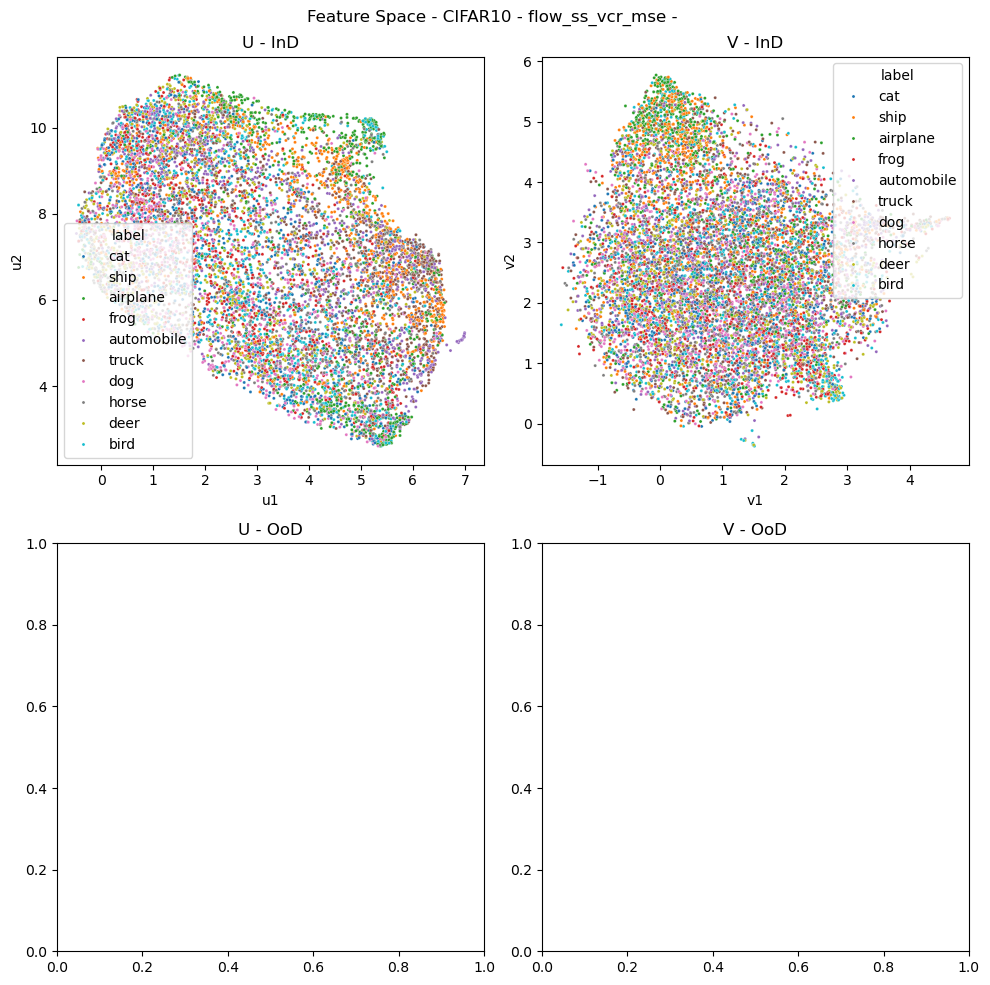

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

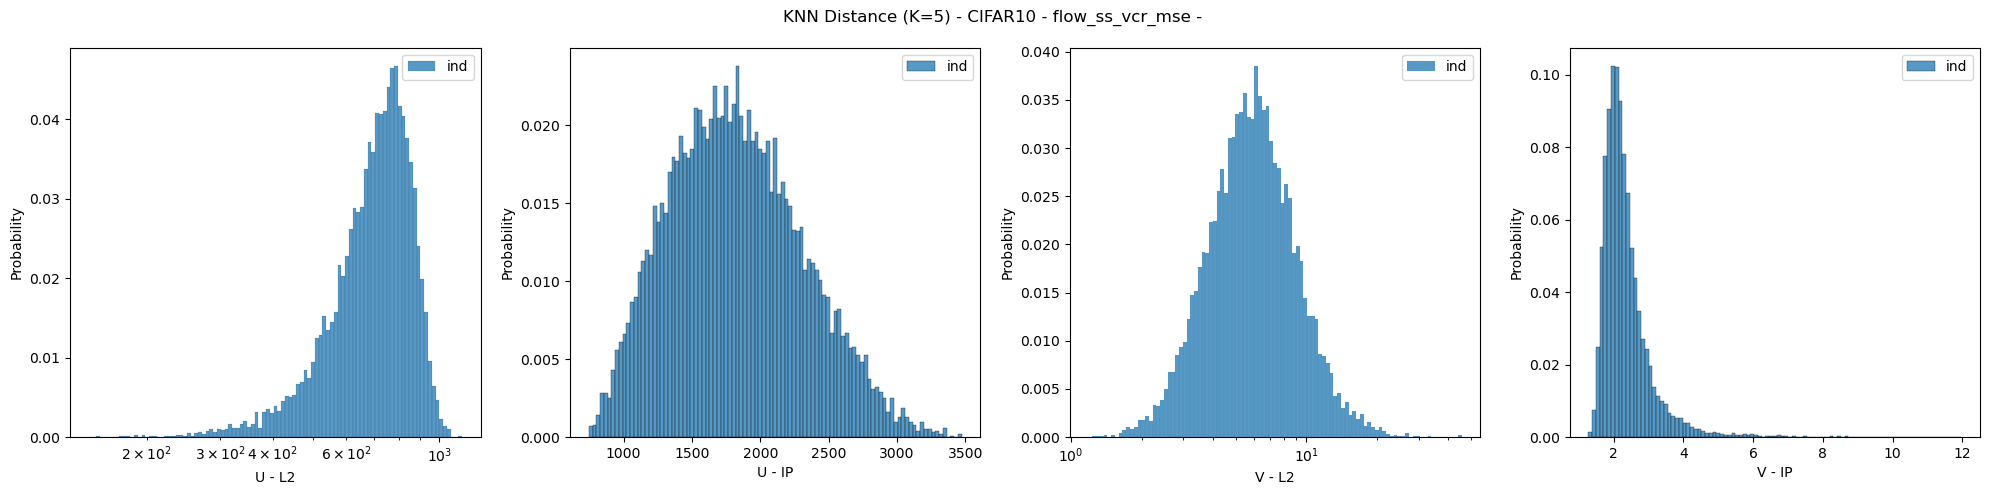

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

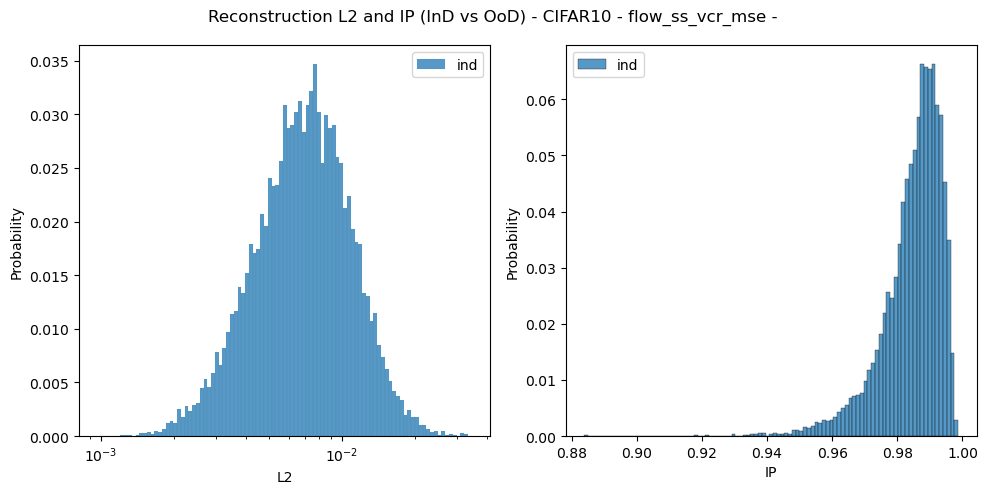

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

42.486088 6.1042385 2.526587 0.5318202
42.428787 6.1795287 2.5167582 0.53264475
42.62697 6.1335707 2.5250363 0.53116894
59.5305 2.7812562 45.830917 0.7645371


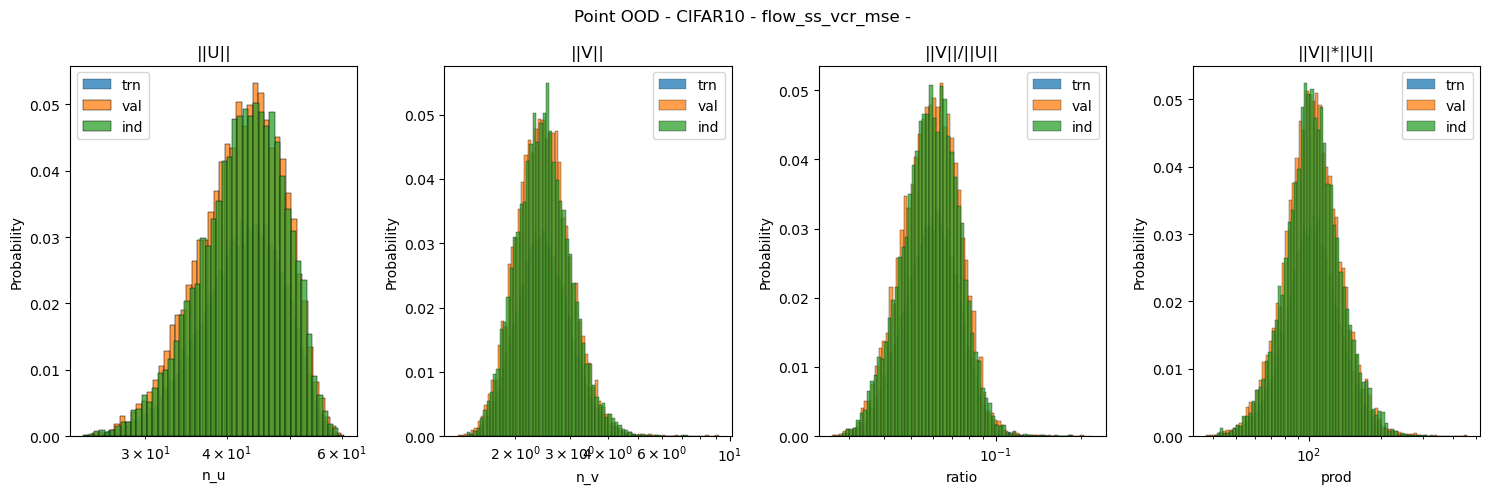

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


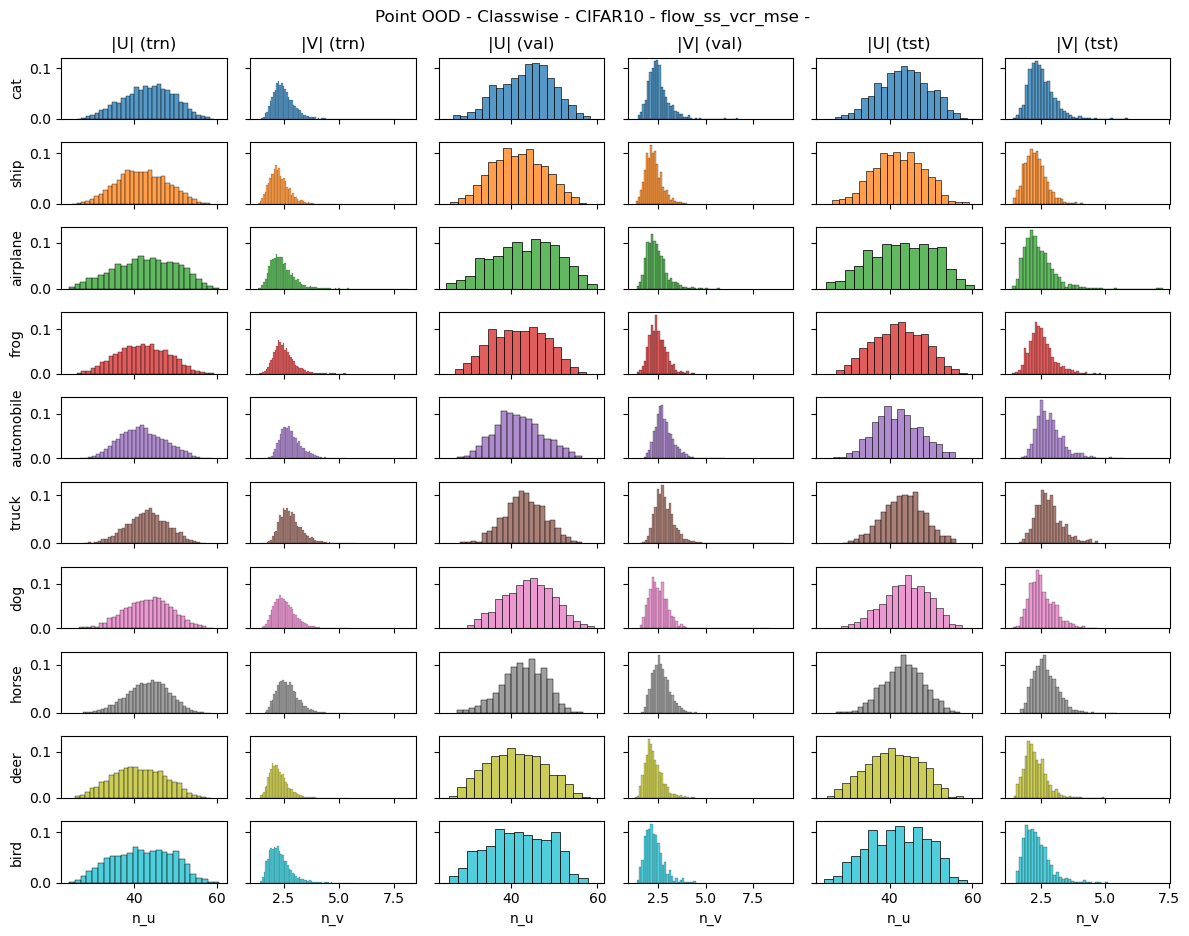

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

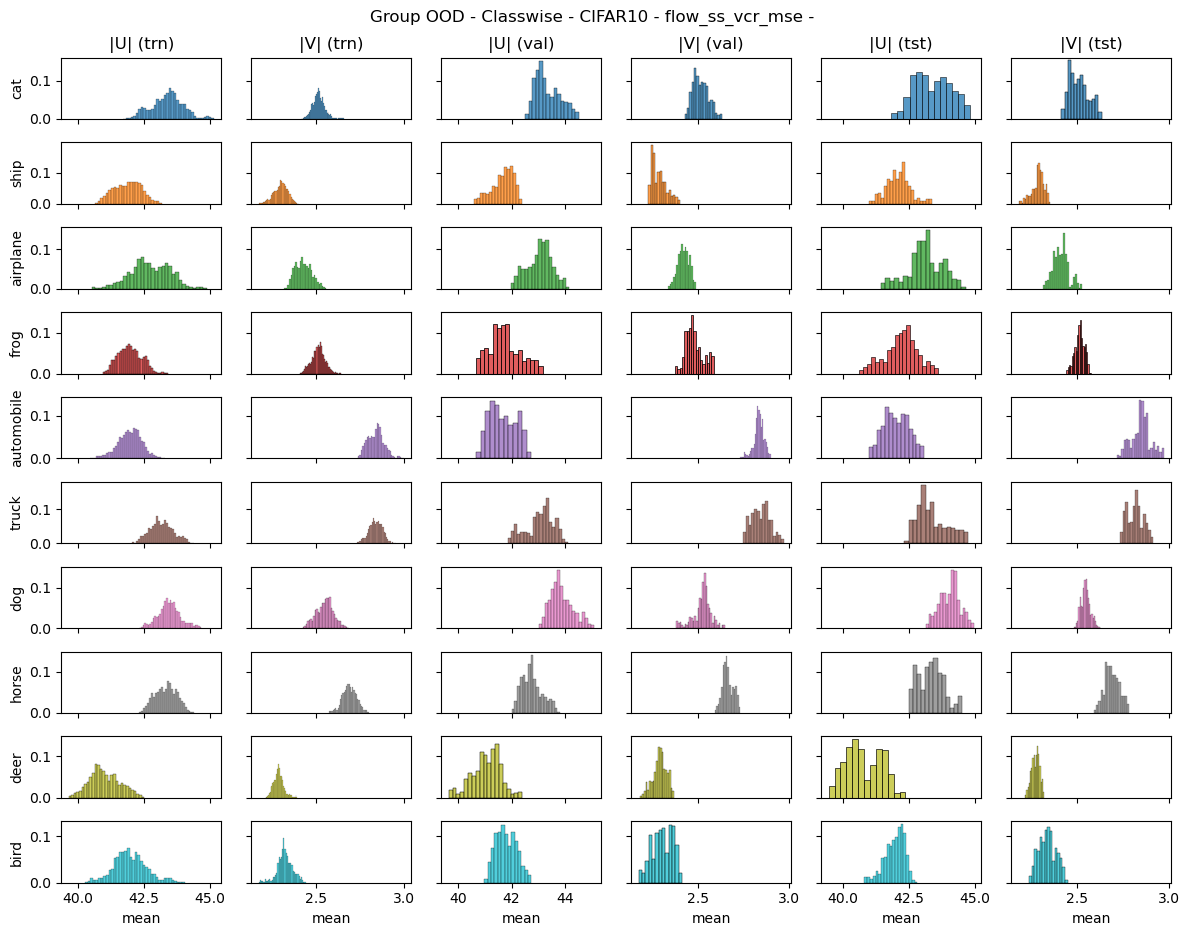

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()